In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as pt
from tqdm import tqdm

In [2]:
def flatten_index(i,j, col=None):
    if col is None:
        col = N
    return (i-1)*col + (j-1)
    # grid is (N+2,N+2), the A has to be (N^2, N^2)
def unflatten_index(ind, col=None):
    if col is None:
        col = N+2
    i = ind//col
    j = ind%col
    return (i,j)

In [3]:


def create_A(alpha):
    A = np.zeros((N*N, N*N))

    for i in range(1, N+1): # will run 1 to N, so i-1 will be 0 to N-1
        for j in range(1, N+1):

            center = flatten_index(i, j)

            # main diagonal
            A[center, center] = 1 + 4*alpha

            # neighbors
            if i > 1:      # up
                A[center, flatten_index(i-1, j)] = -alpha
            if i < N:      # down
                A[center, flatten_index(i+1, j)] = -alpha
            if j > 1:      # left
                A[center, flatten_index(i, j-1)] = -alpha
            if j < N:      # right
                A[center, flatten_index(i, j+1)] = -alpha

    return A


def impose_boundary_condition(A,b, alpha, left_B = 0, right_B = 0, down_B = 0): #NxN
    
    for row in range(1,N+1):
        for col in range(1,N+1):
            i = row
            j = col
            if row == 1: # neumann
                up = flatten_index(i-1,j)
                center = flatten_index(i,j)
                A[center,center] -= alpha
            if row == N : # dirichlet
                down = flatten_index(i+1,j)
                center = flatten_index(i,j)
                b[center] += alpha * down_B
            if col == 1 :
                left = flatten_index(i,j-1)
                center = flatten_index(i,j)
                b[center] += alpha * left_B
            if col == N:
                right = flatten_index(i,j+1)
                center = flatten_index(i,j)
                b[center] += alpha * right_B
    return A,b

def flatten_grid(grid, remove_padding=True):
    if remove_padding:
        b = grid[1:N+1, 1:N+1].flatten()
    else:
        b = grid.flatten()
    return b

def unflatten_grid(grid, left_B = 0, right_B = 0, down_B = 0, add_padding=True):
    if add_padding:
        interior = grid.reshape((N,N))
        g = np.zeros((N+2, N+2))
        g[1:N+1, 1:N+1] = interior

        g[1:N+1, 0] = left_B
        g[1:N+1, N+1] = right_B
        g[N+1, 1:N+1] = down_B
        g[0, 1:N+1] = g[1,1:N+1]

        g[0,0] = 0
        g[0,N+1] = 0
        g[N+1,0] = 0
        g[N+1, N+1] = 0
    else:
        g = grid.reshape((N+2,N+2))
    return g

def create_padded_grid(N, timesteps, left_B = 0, right_B = 0, down_B = 0):
    g = np.zeros((N+2,N+2,timesteps))
    g[1:N+1, 0] = left_B
    g[1:N+1, N+1] = right_B
    g[N+1, 1:N+1] = down_B

    g[0,0] = 0
    g[0,N+1] = 0
    g[N+1,0] = 0
    g[N+1, N+1] = 0

    return g

In [4]:
#exp 1: Equal diffusivity, equal starting 
N = 50
delta_x = 0.1
delta_t = 0.05
timesteps = 1000
D_N = 5
D_C = 5
alpha_N = delta_t * D_N / delta_x
alpha_C = delta_t * D_C / delta_x
C_i = 1
N_i = 1
capacity = C_i + N_i
device='cuda'

In [6]:
grid = create_padded_grid(N,timesteps, left_B = N_i, right_B = N_i, down_B = 0)

In [7]:

b = np.zeros((N**2,timesteps))
b[:,0] = flatten_grid(grid[:,:,0])

b = pt.tensor(b)

In [8]:
b.shape

torch.Size([2500, 1000])

In [9]:

for i in tqdm(range(1,timesteps)):
    
    A = create_A(alpha = alpha_N)
    b_ = b[:,i-1].clone()
    A_, b_ = impose_boundary_condition(A,b_, alpha=alpha_N, left_B = N_i, right_B = N_i)
    A_ = pt.tensor(A_).to(device)
    b_ = pt.tensor(b_).to(device)
    x = pt.linalg.solve(A_,b_)
    b[:,i] = x

  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\umang\AppData\Local\Temp\ipykernel_9152\1369300700.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_ = pt.tensor(b_).to(device)
100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [03:18<00:00,  5.03it/s]


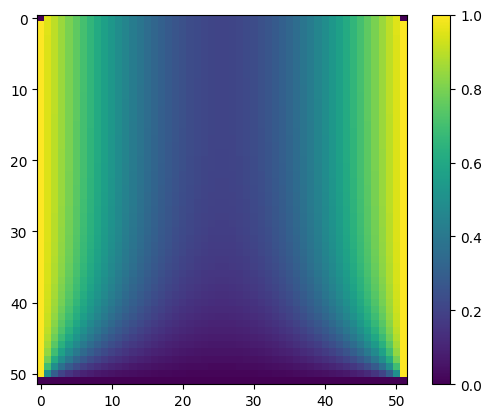

In [10]:
t = 49
cur_b = b[:,t]
g = unflatten_grid(cur_b, left_B = N_i, right_B = N_i)
plt.imshow(g)
plt.colorbar()

In [11]:
N_grid = np.zeros_like(grid)
for i, cur_b in enumerate(b.T):
    N_grid[:,:,i] = unflatten_grid(cur_b, left_B = N_i, right_B = N_i)

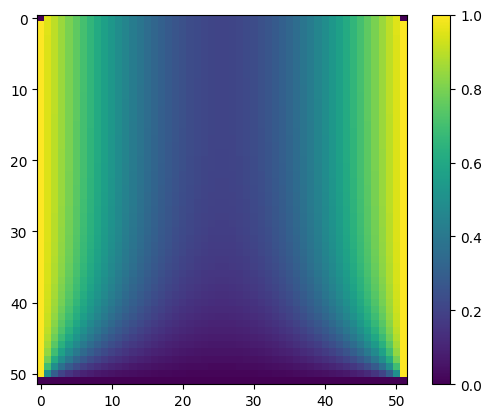

In [12]:
plt.imshow(N_grid[:,:,49])
plt.colorbar()

In [13]:
grid = create_padded_grid(N,timesteps, left_B = 0, right_B = 0, down_B = C_i)

b = np.zeros((N**2,timesteps))
b[:,0] = flatten_grid(grid[:,:,0])

b = pt.tensor(b)

In [14]:

for i in tqdm(range(1,timesteps)):
    
    A = create_A(alpha = alpha_N)
    b_ = b[:,i-1].clone()
    A_, b_ = impose_boundary_condition(A,b_, alpha=alpha_C, down_B = C_i)
    A_ = pt.tensor(A_).to(device)
    b_ = pt.tensor(b_).to(device)
    x = pt.linalg.solve(A_,b_)
    b[:,i] = x

  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\umang\AppData\Local\Temp\ipykernel_9152\1763625010.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_ = pt.tensor(b_).to(device)
100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [03:13<00:00,  5.15it/s]


In [15]:
C_grid = np.zeros_like(grid)
for i, cur_b in enumerate(b.T):
    C_grid[:,:,i] = unflatten_grid(cur_b, down_B = C_i)

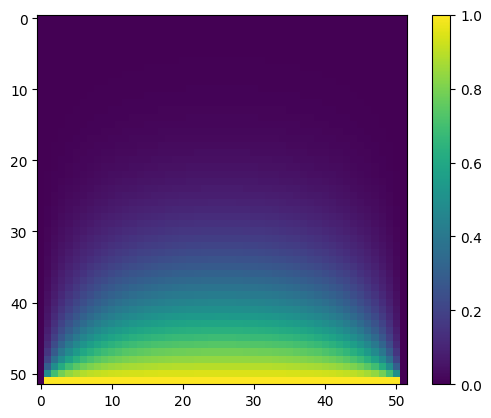

In [16]:
plt.imshow(C_grid[:,:,49])
plt.colorbar()

In [17]:
capacity2 = 0
for t in range(timesteps):
    for i in range(N+2):
        for j in range(N+2):
            capacity2 = max(capacity2, N_grid[i,j,t], C_grid[i,j,t])

In [18]:
capacity2

1.0

In [19]:
NCV_grid = np.zeros((timesteps,N+2,N+2,3))
NCV_grid2 = np.zeros((timesteps,N+2,N+2,3))

In [20]:
for t in range(timesteps):
    for i in range(N+2):
        for j in range(N+2):
            NCV_grid2[t,i,j] = [N_grid[i,j,t], C_grid[i,j,t], capacity2 - N_grid[i,j,t] - C_grid[i,j,t]] # sums to capacity2

In [21]:
N_color = np.array([0,0,1])
C_color = np.array([1,0,0]) 
V_color = np.array([0,0,0])

NCV_color1 = np.zeros((timesteps,N+2,N+2,3))
N_color1 = np.zeros((timesteps,N+2,N+2,3))
C_color1 = np.zeros((timesteps,N+2,N+2,3))
for t in range(timesteps):
    for i in range(N+2):
        for j in range(N+2):
            NCV_color1[t,i,j] = N_color * NCV_grid2[t,i,j,0] + C_color * NCV_grid2[t,i,j,1] + V_color * NCV_grid2[t,i,j,2]

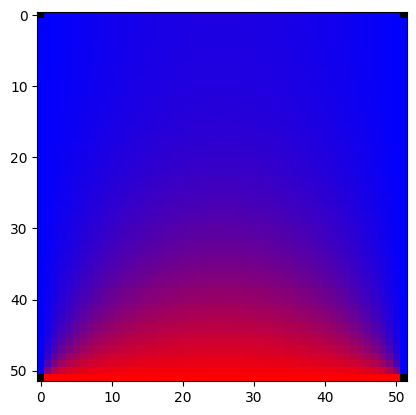

In [22]:
plt.imshow(NCV_color1[999])

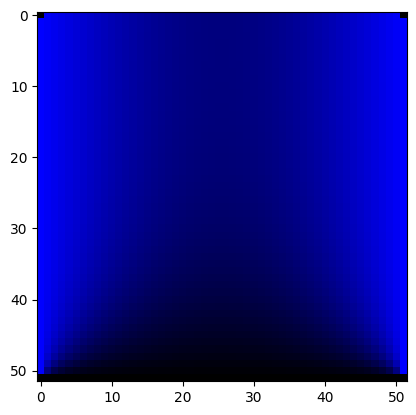

In [23]:
for t in range(timesteps):
    for i in range(N+2):
        for j in range(N+2):
            N_color1[t,i,j] = N_color * NCV_grid2[t,i,j,0]

plt.imshow(N_color1[99])

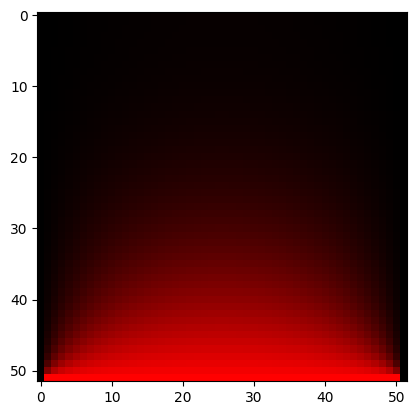

In [24]:
for t in range(timesteps):
    for i in range(N+2):
        for j in range(N+2):
            C_color1[t,i,j] = C_color * NCV_grid2[t,i,j,1]

plt.imshow(C_color1[99])

In [25]:
C_color

array([1, 0, 0])

In [26]:
exp = {
    'N': N,
    'delta_x':delta_x,
    'delta_t': delta_t,
    'timesteps': timesteps,
    'D_N': D_N,
    'D_C': D_C,
    'C_i':C_i,
    'N_i':N_i,
    'NCV_grid': NCV_grid2,
    'NCV_color':NCV_color1
}


In [30]:
np.save('dataNCN/exp1.npy', exp)

In [8]:
left_B = N_i
right_B = 0
down_B = N_i

In [9]:
grid = create_padded_grid(N,timesteps, left_B = left_B, right_B = right_B, down_B = down_B)

In [10]:

b = np.zeros((N**2,timesteps))
b[:,0] = flatten_grid(grid[:,:,0])

b = pt.tensor(b)

In [11]:

for i in tqdm(range(1,timesteps)):
    
    A = create_A(alpha = alpha_N)
    b_ = b[:,i-1].clone()
    A_, b_ = impose_boundary_condition(A,b_, alpha=alpha_N, left_B = left_B, right_B = right_B, down_B = down_B)
    A_ = pt.tensor(A_).to(device)
    b_ = pt.tensor(b_).to(device)
    x = pt.linalg.solve(A_,b_)
    b[:,i] = x

  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\umang\AppData\Local\Temp\ipykernel_9240\3583232147.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_ = pt.tensor(b_).to(device)
100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [03:21<00:00,  4.95it/s]


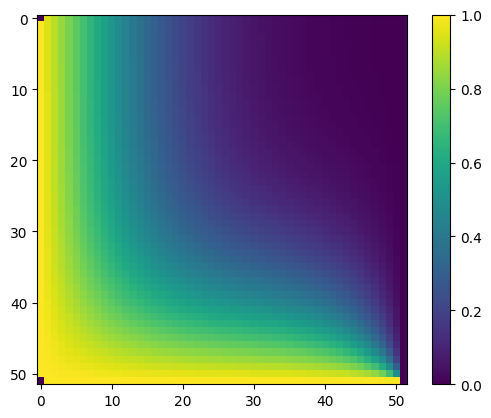

In [12]:
t = 49
cur_b = b[:,t]
g = unflatten_grid(cur_b, left_B = left_B, right_B = right_B, down_B = down_B)
plt.imshow(g)
plt.colorbar()

In [13]:
N_grid = np.zeros_like(grid)
for i, cur_b in enumerate(b.T):
    N_grid[:,:,i] = unflatten_grid(cur_b, left_B = left_B, right_B = right_B, down_B = down_B)

In [14]:
left_B = 0
right_B = C_i
down_B = 0

grid = create_padded_grid(N,timesteps, left_B = left_B, right_B = right_B, down_B = down_B)

b = np.zeros((N**2,timesteps))
b[:,0] = flatten_grid(grid[:,:,0])

b = pt.tensor(b)

In [15]:

for i in tqdm(range(1,timesteps)):
    
    A = create_A(alpha = alpha_N)
    b_ = b[:,i-1].clone()
    A_, b_ = impose_boundary_condition(A,b_, alpha=alpha_C,left_B = left_B, right_B = right_B, down_B = down_B)
    A_ = pt.tensor(A_).to(device)
    b_ = pt.tensor(b_).to(device)
    x = pt.linalg.solve(A_,b_)
    b[:,i] = x

  0%|                                                                                          | 0/999 [00:00<?, ?it/s]C:\Users\umang\AppData\Local\Temp\ipykernel_9240\2906463851.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_ = pt.tensor(b_).to(device)
100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [03:19<00:00,  5.00it/s]


In [21]:
C_grid = np.zeros_like(grid)
for i, cur_b in enumerate(b.T):
    C_grid[:,:,i] = unflatten_grid(cur_b, left_B = left_B, right_B = right_B, down_B = down_B)

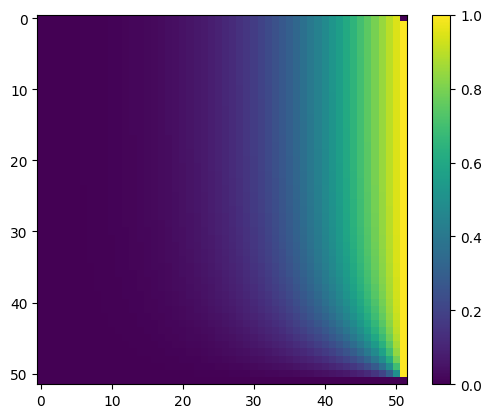

In [22]:
plt.imshow(C_grid[:,:,49])
plt.colorbar()

In [23]:
capacity2 = 0
for t in range(timesteps):
    for i in range(N+2):
        for j in range(N+2):
            capacity2 = max(capacity2, N_grid[i,j,t], C_grid[i,j,t])

In [24]:
NCV_grid2 = np.zeros((timesteps,N+2,N+2,3))
for t in range(timesteps):
    for i in range(N+2):
        for j in range(N+2):
            NCV_grid2[t,i,j] = [N_grid[i,j,t], C_grid[i,j,t], capacity2 - N_grid[i,j,t] - C_grid[i,j,t]] # sums to capacity2

In [25]:
N_color = np.array([0,0,1])
C_color = np.array([1,0,0]) 
V_color = np.array([0,0,0])

NCV_color1 = np.zeros((timesteps,N+2,N+2,3))
N_color1 = np.zeros((timesteps,N+2,N+2,3))
C_color1 = np.zeros((timesteps,N+2,N+2,3))
for t in range(timesteps):
    for i in range(N+2):
        for j in range(N+2):
            NCV_color1[t,i,j] = N_color * NCV_grid2[t,i,j,0] + C_color * NCV_grid2[t,i,j,1] + V_color * NCV_grid2[t,i,j,2]

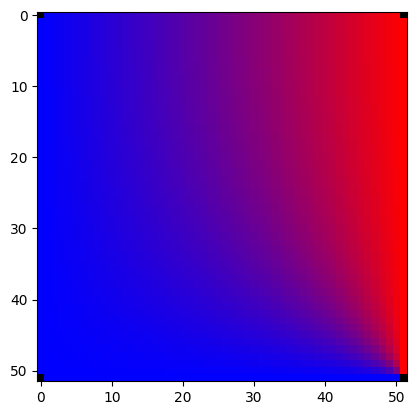

In [34]:
plt.imshow(NCV_color1[999])

In [27]:
exp = {
    'N': N,
    'delta_x':delta_x,
    'delta_t': delta_t,
    'timesteps': timesteps,
    'D_N': D_N,
    'D_C': D_C,
    'C_i':C_i,
    'N_i':N_i,
    'NCV_grid': NCV_grid2,
    'NCV_color':NCV_color1
}


In [28]:
np.save('dataNNC/exp1.npy', exp)